In [1]:
import torch
import torchvision
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
from collections import Counter
import datetime

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, confusion_matrix, f1_score, accuracy_score, recall_score, classification_report
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Setting

In [2]:
plt.style.use("dark_background")

# Model

In [3]:
class BiLSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, lstm_layer, dropout = 0.2, num_class = 8):
        super(BiLSTM, self).__init__()
        self.input_size = feature_size
        self.hidden_dim = hidden_size
        self.num_class = num_class
        self.dropout = nn.Dropout(p = dropout)
        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = hidden_size,
                            num_layers = lstm_layer,
                            dropout = dropout,
                            bidirectional = True)
        self.hidden2label = nn.Linear(hidden_size*2, self.num_class)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        label_space = self.hidden2label(lstm_out)
        label_scores = nn.Softmax(dim = 1)(label_space)

        return label_scores

# Data

In [4]:
data_df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val_df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [5]:
def is_viecle(label):
    if label.max() == 8:
        label -= 1
    return [1 if l > 3 else 0 for l in label]

In [6]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
#  'longitude',
#  'altitude',
#  'time_dlt',
#  'valid_dlt',
#  'east',
#  'north',
#  'east_dlt',
#  'north_dlt',
#  'east_speed',
#  'north_speed',
 'cells_ctype_mode',
#  'speed_dif',
#  'speed_dlt',
#  'speed'
 ]
X_train, y_train = data_df.drop(col_drop_x + col_drop, axis = 1).fillna(0).copy(), data_df[col_label].copy()
X_train = X_train.apply(lambda x: (x-min(x))/(max(x)-min(x)), axis = 0)
# y_train -= 1
y_train = is_viecle(y_train)

X_val, y_val = val_df.drop(col_drop_x + col_drop, axis = 1).fillna(0).copy(), val_df[col_label].copy()
X_val = X_val.apply(lambda x: (x-min(x))/(max(x)-min(x)), axis = 0)
# y_val -= 1
y_val = is_viecle(y_val)

In [7]:
class TMR_Dataset(Dataset):
    def __init__(self, x_array, label):
        super().__init__()
        self.len, self.feature_size = x_array.shape
        self.data = x_array
        self.data = torch.tensor(self.data).float()
        self.label = label
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data[idx,:], self.label[idx])

In [9]:
BATCH_SIZE = 2048
EPOCHS = 100
LR = 0.0005

In [10]:
data = TMR_Dataset(np.array(X_train), y_train)
train_loader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = False)
X_val = torch.tensor(np.array(X_val), dtype = torch.float32)

In [11]:
# net = BiLSTM(feature_size = 32, hidden_size = 4, lstm_layer = 4)
# X, y = next(iter(train_loader))
# net(X.unsqueeze(0)).squeeze().argmax(dim = 1)

In [33]:
writer = SummaryWriter(log_dir = 'log', comment = "")

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net = BiLSTM(feature_size = 32, hidden_size = 128, lstm_layer = 8, dropout = 0.75, num_class = 1).to(device)
net = BiLSTM(feature_size = 45, hidden_size = 128, lstm_layer = 8, dropout = 0.5, num_class = 2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = LR, weight_decay = 0.95)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

In [118]:
global_step = 0
for epoch in range(EPOCHS):
    for i, (X, y) in enumerate(train_loader):
        # y = y.float()
        output = net(X.unsqueeze(0)).squeeze()
        loss = criterion(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1

        if i % 100 == 0:
            net.eval()
            if net.num_class == 1: # !!! not complete yet !!!
                test_pred = net(X_val.unsqueeze(0)).squeeze()
                accuracy_train = accuracy_score(y, (output > 0.5).int())
                accuracy_val = accuracy_score(y_val, (test_pred > 0.5).int())
            else:
                test_pred = net(X_val.unsqueeze(0)).squeeze().argmax(dim = 1)
                accuracy_train = accuracy_score(y, output.argmax(dim = 1))
                accuracy_val = accuracy_score(y_val, test_pred)
            print('epoch:{:<2d} | iteration:{:<4d} | loss:{:<6.4f} | accuracy_val:{:<4.2f} | accuracy_train:{:<4.2f}'.format(epoch, i, loss, accuracy_val, accuracy_train))

            # summary writer
            writer.add_scalar('loss_train', loss, global_step)
            writer.add_scalar('accuracy/train', accuracy_train, global_step)
            writer.add_scalar('accuracy/val', accuracy_val, global_step)
            writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], global_step)
            net.train()

epoch:0  | iteration:0    | loss:0.6931 | accuracy_val:0.47 | accuracy_train:0.60
epoch:1  | iteration:0    | loss:0.6932 | accuracy_val:0.46 | accuracy_train:0.65
epoch:2  | iteration:0    | loss:0.6932 | accuracy_val:0.45 | accuracy_train:0.40
epoch:3  | iteration:0    | loss:0.6931 | accuracy_val:0.45 | accuracy_train:0.70
epoch:4  | iteration:0    | loss:0.6931 | accuracy_val:0.46 | accuracy_train:0.55
epoch:5  | iteration:0    | loss:0.6931 | accuracy_val:0.50 | accuracy_train:0.60
epoch:6  | iteration:0    | loss:0.6931 | accuracy_val:0.49 | accuracy_train:0.60
epoch:7  | iteration:0    | loss:0.6931 | accuracy_val:0.46 | accuracy_train:0.55
epoch:8  | iteration:0    | loss:0.6932 | accuracy_val:0.50 | accuracy_train:0.45
epoch:9  | iteration:0    | loss:0.6932 | accuracy_val:0.49 | accuracy_train:0.50
epoch:10 | iteration:0    | loss:0.6931 | accuracy_val:0.48 | accuracy_train:0.70
epoch:11 | iteration:0    | loss:0.6931 | accuracy_val:0.49 | accuracy_train:0.65
epoch:12 | itera

KeyboardInterrupt: 

# Test (Tiny DataSet)

In [252]:
global_step

38310

In [87]:
# data = TMR_Dataset(np.array(X_train)[:20,:], y_train[:20] - 1)
data = TMR_Dataset(np.array(X_train)[:20,:], [0]*12 + [1]*8)
train_loader = DataLoader(data, batch_size = 20, shuffle = False)

In [88]:
X, y = next(iter(train_loader))

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BiLSTM(feature_size = 32, hidden_size = 128, lstm_layer = 8, num_class = 2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()

In [101]:
global_step = 0
accs = []
for epoch in range(1000):
    output = net(X.unsqueeze(0)).squeeze()
    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pred = output.argmax(dim = 1)
    accuracy = accuracy_score(y, pred)
    # print(epoch, accuracy)
    accs.append(accuracy)

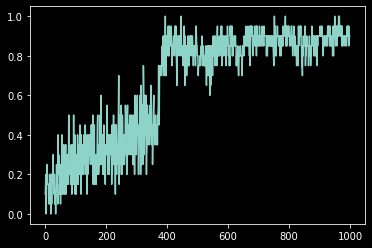

In [102]:
plt.plot(accs)

In [104]:
max(accs)

1.0